# Part1 Time Series Prediction(LSTM)

In [262]:
#importing the required libraries
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

### 1.Loading the financial data(web scraping)

In [261]:
crypto = 'BTC'
against = 'INR'


start =dt.datetime(2020,1,1)
end = dt.datetime.now()

df = web.DataReader(f'{crypto}-{against}','yahoo',start,end)
df.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,523079.50000,510724.78125,520253.96875,512910.81250,1509295725753,512910.81250
2020-01-01,516907.31250,511971.78125,513003.00000,512853.96875,1322395074997,512853.96875
2020-01-02,514302.40625,494834.96875,513023.28125,498416.75000,1484238993887,498416.75000
2020-01-03,531793.18750,493609.68750,498342.43750,527076.25000,2017307990333,527076.25000
2020-01-04,532996.62500,524538.06250,527111.50000,531796.12500,1323579350948,531796.12500
2020-01-05,541400.62500,531089.43750,531781.43750,531863.18750,1415543274095,531863.18750
2020-01-06,558713.87500,531717.93750,531801.06250,557805.00000,1671160912507,557805.00000
2020-01-07,588557.56250,557733.81250,557766.43750,587512.37500,2070281271282,587512.37500
2020-01-08,600555.68750,568201.18750,587385.93750,577281.12500,2262906174516,577281.12500


### 2.Preparing the data(Data Pre-processing)

In [227]:
#removing unnecessary coloumns
df = df.reset_index()
df = df.drop(['Date','Adj Close'], axis = 1)

In [228]:
df.head()

,High,Low,Open,Close,Volume
0,9535.138672,9173.390625,9458.171875,9241.383789,637207510947
1,9465.183594,9218.943359,9242.794922,9316.764648,565210538368
2,9318.048828,9058.295898,9318.048828,9090.780273,573137797678
3,9655.730469,9029.173828,9090.856445,9628.295898,751828899741
4,9763.279297,9547.123047,9628.067383,9692.712891,533249138908


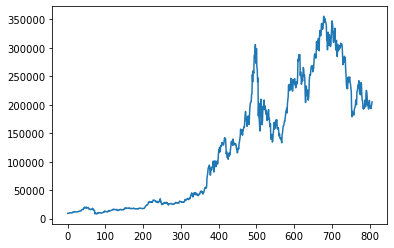

In [229]:
plt.plot(df.Close)

In [230]:
df1 = df.reset_index()['Close']

In [231]:
df1.shape

(807,)

### 3.Downscaling the data (MinMax scaler)

In [232]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [233]:
df1.shape

(807, 1)

In [234]:
df1

array([[2.94315888e-03],
       [3.16009168e-03],
       [2.50974858e-03],
       [4.05662357e-03],
       [4.24200429e-03],
       [4.49239178e-03],
       [6.16399399e-03],
       [6.07703820e-03],
       [5.39239448e-03],
       [4.82352975e-03],
       [5.75982563e-03],
       [5.53548469e-03],
       [6.13802332e-03],
       [5.70473386e-03],
       [1.01877924e-02],
       [1.01812161e-02],
       [9.91635238e-03],
       [1.12642585e-02],
       [1.22018134e-02],
       [1.04876762e-02],
       [1.05135794e-02],
       [1.11094434e-02],
       [1.07879506e-02],
       [9.79373294e-03],
       [9.81633116e-03],
       [9.45358210e-03],
       [1.08486210e-02],
       [1.14949790e-02],
       [1.25070538e-02],
       [1.22714966e-02],
       [1.43880148e-02],
       [1.34181153e-02],
       [1.41411150e-02],
       [1.51583160e-02],
       [1.53194432e-02],
       [1.50767139e-02],
       [1.81891979e-02],
       [1.99195229e-02],
       [2.21874331e-02],
       [2.22739673e-02],


### 4.Splitting the dataset into train and test split

In [235]:
training_size = int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [236]:
training_size,test_size

(524, 283)

In [237]:
#converting an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[ i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [238]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [239]:
print(X_train.shape), print(y_train.shape)

(423, 100)
(423,)


(None, None)

In [240]:
print(X_test.shape), print(y_test.shape)

(182, 100)
(182,)


(None, None)

In [241]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### 5.LSTM model

In [242]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM 

In [243]:
model = Sequential()
model.add(LSTM(units = 50,activation = 'tanh', return_sequences = True,
              input_shape = (100,1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60,activation = 'tanh', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80,activation = 'tanh'))
model.add(Dropout(0.5))


model.add(Dense(units = 1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [244]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 100, 60)           26640     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 60)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 80)                45120     
_________________________________________________________________
dropout_16 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [245]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
7/7 [==============================] - 2s 233ms/step - loss: 0.0298 - val_loss: 0.0097
Epoch 2/50
7/7 [==============================] - 1s 100ms/step - loss: 0.0107 - val_loss: 0.0434
Epoch 3/50
7/7 [==============================] - 1s 102ms/step - loss: 0.0079 - val_loss: 0.0273
Epoch 4/50
7/7 [==============================] - 1s 98ms/step - loss: 0.0055 - val_loss: 0.0129
Epoch 5/50
7/7 [==============================] - 1s 99ms/step - loss: 0.0058 - val_loss: 0.0101
Epoch 6/50
7/7 [==============================] - 1s 99ms/step - loss: 0.0053 - val_loss: 0.0156
Epoch 7/50
7/7 [==============================] - 1s 100ms/step - loss: 0.0063 - val_loss: 0.0091
Epoch 8/50
7/7 [==============================] - 1s 100ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 9/50
7/7 [==============================] - 1s 98ms/step - loss: 0.0044 - val_loss: 0.0106
Epoch 10/50
7/7 [==============================] - 1s 99ms/step - loss: 0.0055 - val_loss: 0.0096
Epoch 11/50
7/7 [=======

### 6.Tesing our model on testdata

In [246]:
#Prediction and Performance Matrix
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [247]:
#Upscaling the data
#back to orirginal form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [248]:
test_predict

array([[225166.06],
       [223390.78],
       [223954.55],
       [225707.27],
       [228029.88],
       [230090.39],
       [230276.67],
       [227840.23],
       [224322.84],
       [220965.11],
       [217683.58],
       [214661.53],
       [212544.89],
       [211089.14],
       [209810.16],
       [208752.66],
       [208429.52],
       [209907.45],
       [213426.3 ],
       [218568.06],
       [224468.9 ],
       [230766.02],
       [237072.48],
       [242854.16],
       [247615.66],
       [251052.64],
       [252535.42],
       [252585.27],
       [251431.38],
       [249839.34],
       [248820.  ],
       [248891.28],
       [249841.08],
       [251388.58],
       [252836.75],
       [254310.02],
       [256691.06],
       [259517.67],
       [262055.03],
       [264691.2 ],
       [266973.03],
       [269183.5 ],
       [270849.34],
       [271059.66],
       [271130.4 ],
       [271970.84],
       [273295.7 ],
       [274655.62],
       [275880.38],
       [277805.88],


In [249]:
# RMSE performance metrics for training dataset
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

96790.51181940685

In [250]:
# RMSE for test data
math.sqrt(mean_squared_error(y_test,test_predict))

242322.3426947212

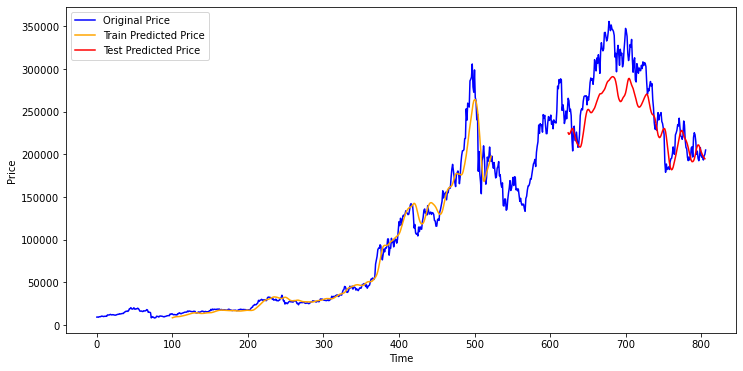

In [251]:
# Plotting 
plt.figure(figsize=(12,6)) 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(df1),'b',label ='Original Price')
plt.plot(trainPredictPlot,'orange',label ='Train Predicted Price')
plt.plot(testPredictPlot,'r',label='Test Predicted Price')
plt.legend()
plt.show()

### 7.Predicting future 30 days price

In [252]:
tlen=len(test_data)
tlen

283

In [253]:
x_input=test_data[tlen-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [254]:
#storing data collected into list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [255]:
temp_input

[0.9127739851136214,
 0.9394246973227561,
 0.8726591967235802,
 0.8288597153236393,
 0.8663567636928821,
 0.8773940254426615,
 0.8021312119533808,
 0.796041917710964,
 0.8576757197713601,
 0.8449108647207858,
 0.8254344760707826,
 0.8432329138719449,
 0.8345391895415,
 0.8340083210743165,
 0.852012163513637,
 0.8411574636795583,
 0.8638080014993459,
 0.851396489191032,
 0.8611885527709621,
 0.8588504112703181,
 0.8475731210707823,
 0.7938638551314766,
 0.7550342846415738,
 0.7718787240182264,
 0.7660666900645317,
 0.7847371083261057,
 0.7975147337175813,
 0.7817359882823354,
 0.7901695393999121,
 0.7368409555242329,
 0.7084452481765259,
 0.6584916765438911,
 0.6369036400802848,
 0.6511445037227018,
 0.6334230476948597,
 0.6642139134173753,
 0.6925533233467431,
 0.6678426237708592,
 0.6827308177921999,
 0.6871119440411081,
 0.6926649289316618,
 0.6628004974823444,
 0.6558003721649431,
 0.6396538049389501,
 0.6192872246029543,
 0.524177502713578,
 0.4914630819098181,
 0.5192555705138977,

In [256]:
#logic for prediction
from numpy import array

lst_output=[]
n_steps = 100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else :
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        

print(lst_output)

[0.53615785]
101
1 day input [0.9394247  0.8726592  0.82885972 0.86635676 0.87739403 0.80213121
 0.79604192 0.85767572 0.84491086 0.82543448 0.84323291 0.83453919
 0.83400832 0.85201216 0.84115746 0.863808   0.85139649 0.86118855
 0.85885041 0.84757312 0.79386386 0.75503428 0.77187872 0.76606669
 0.78473711 0.79751473 0.78173599 0.79016954 0.73684096 0.70844525
 0.65849168 0.63690364 0.6511445  0.63342305 0.66421391 0.69255332
 0.66784262 0.68273082 0.68711194 0.69266493 0.6628005  0.65580037
 0.6396538  0.61928722 0.5241775  0.49146308 0.51925557 0.50057301
 0.50477666 0.50926737 0.50078197 0.52611549 0.53690598 0.53862008
 0.55314297 0.57694671 0.55403649 0.55186702 0.61727927 0.62395186
 0.63311557 0.65152078 0.64758679 0.67376285 0.64535239 0.61360285
 0.61142141 0.60252089 0.61528894 0.66427336 0.65109679 0.59891714
 0.57508035 0.57034624 0.54132587 0.53068341 0.54316898 0.53287105
 0.54016111 0.57347722 0.57721848 0.54274162 0.60881366 0.62477541
 0.61805529 0.5953664  0.55186733

In [257]:
day_new=np.arange(1,101)
day_pred = np.arange(101,131)

In [258]:
datalen=len(df1)

<function matplotlib.pyplot.show(*args, **kw)>

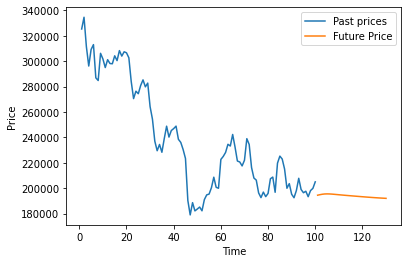

In [259]:
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(day_new,scaler.inverse_transform(df1[datalen-100:]),label='Past prices')
plt.plot(day_pred,scaler.inverse_transform(lst_output),label='Future Price')
plt.legend()
plt.show